In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

import matplotlib.pyplot as plt


In [21]:
# Đường dẫn dữ liệu
DATA_DIR = "datasets/"

# Chỉ lấy các cột thực sự cần dùng
student_info = pd.read_csv(
    DATA_DIR + "studentInfo.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "final_result",
        "gender",
        "age_band",
        "highest_education",
    ],
)

student_vle = pd.read_csv(
    DATA_DIR + "studentVle.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "date",
        "sum_click",
    ],
)

student_ass = pd.read_csv(
    DATA_DIR + "studentAssessment.csv",
    usecols=[
        "id_student",
        "id_assessment",
        "score",
        "date_submitted",
    ],
)

assessments = pd.read_csv(
    DATA_DIR + "assessments.csv",
    usecols=[
        "id_assessment",
        "code_module",
        "code_presentation",
        "date",
    ],
)

student_info.head()


,code_module,code_presentation,id_student,gender,highest_education,age_band,final_result
0,AAA,2013J,11391,M,HE Qualification,55<=,Pass
1,AAA,2013J,28400,F,HE Qualification,35-55,Pass
2,AAA,2013J,30268,F,A Level or Equivalent,35-55,Withdrawn
3,AAA,2013J,31604,F,A Level or Equivalent,35-55,Pass
4,AAA,2013J,32885,F,Lower Than A Level,0-35,Pass


In [22]:
# Chọn 1 course 
MODULE = "EEE"
PRESENTATION = "2014J"
EARLY_DAYS = 28 

# Lọc ra đúng học viên trong module này
students = student_info[
    (student_info["code_module"] == MODULE)
    & (student_info["code_presentation"] == PRESENTATION)
].copy()

# final_result -> dropout (1 = Withdrawn, 0 = còn lại)
students["dropout"] = np.where(students["final_result"] == "Withdrawn", 1, 0)

students[["id_student", "final_result", "dropout"]].head(), students["dropout"].value_counts()


(       id_student final_result  dropout
 21109       28770         Fail        0
 21110       46048    Withdrawn        1
 21111       47061         Pass        0
 21112       60809         Pass        0
 21113       62034         Pass        0,
 dropout
 0    882
 1    306
 Name: count, dtype: int64)

In [23]:
# Lọc log học 4 tuần đầu
vle_early = student_vle[
    (student_vle["code_module"] == MODULE)
    & (student_vle["code_presentation"] == PRESENTATION)
    & (student_vle["date"] <= EARLY_DAYS)
].copy()

# Tổng click, số ngày active, trung bình click/ngày
vle_agg = (
    vle_early.groupby("id_student")
    .agg(
        total_clicks=("sum_click", "sum"),
        active_days=("date", "nunique"),
        avg_clicks_per_day=("sum_click", lambda x: x.sum() / EARLY_DAYS),
    )
    .reset_index()
)

vle_agg.head()


,id_student,total_clicks,active_days,avg_clicks_per_day
0,60809,292,14,10.428571
1,62034,438,20,15.642857
2,67539,655,27,23.392857
3,67685,493,25,17.607143
4,70827,139,5,4.964286


In [24]:
# Join để lấy ngày thi, module/presentation
ass = student_ass.merge(
    assessments,
    on="id_assessment",
    how="left",
)

ass_early = ass[
    (ass["code_module"] == MODULE)
    & (ass["code_presentation"] == PRESENTATION)
    & (ass["date"] <= EARLY_DAYS)
].copy()

ass_agg = (
    ass_early.groupby("id_student")
    .agg(
        num_assessments=("id_assessment", "nunique"),
        avg_score=("score", "mean"),
        missed_assessments=("score", lambda s: s.isna().sum()),
    )
    .reset_index()
)

ass_agg.head()


,id_student,num_assessments,avg_score,missed_assessments


In [25]:
data = (
    students.merge(vle_agg, on="id_student", how="left")
    .merge(ass_agg, on="id_student", how="left")
)

# Điền NaN cho những học viên chưa có hoạt động/điểm
for col in [
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "num_assessments",
    "avg_score",
    "missed_assessments",
]:
    data[col] = data[col].fillna(0)

data.head(), data.isna().sum()


(  code_module code_presentation  id_student gender      highest_education  \
 0         EEE             2014J       28770      M     Lower Than A Level   
 1         EEE             2014J       46048      M  A Level or Equivalent   
 2         EEE             2014J       47061      M  A Level or Equivalent   
 3         EEE             2014J       60809      M     Lower Than A Level   
 4         EEE             2014J       62034      M     Lower Than A Level   
 
   age_band final_result  dropout  total_clicks  active_days  \
 0     0-35         Fail        0           0.0          0.0   
 1    35-55    Withdrawn        1           0.0          0.0   
 2     0-35         Pass        0           0.0          0.0   
 3     0-35         Pass        0         292.0         14.0   
 4     0-35         Pass        0         438.0         20.0   
 
    avg_clicks_per_day  num_assessments  avg_score  missed_assessments  
 0            0.000000              0.0        0.0                 0.0 

In [26]:
# Feature số
feature_cols_num = [
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "num_assessments",
    "avg_score",
    "missed_assessments",
]

# Feature phân loại
feature_cols_cat = [
    "age_band",
    "gender",
    "highest_education",
]

X = data[feature_cols_num + feature_cols_cat]
y = data["dropout"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((831, 9), (357, 9), 0.2575210589651023, 0.25770308123249297)

In [36]:
X_train.head(5)


,total_clicks,active_days,avg_clicks_per_day,num_assessments,avg_score,missed_assessments,age_band,gender,highest_education
375,274.0,12.0,9.785714,0.0,0.0,0.0,0-35,M,Lower Than A Level
806,0.0,0.0,0.000000,0.0,0.0,0.0,0-35,M,Lower Than A Level
898,319.0,15.0,11.392857,0.0,0.0,0.0,0-35,M,Lower Than A Level
1146,690.0,16.0,24.642857,0.0,0.0,0.0,0-35,M,HE Qualification
790,255.0,11.0,9.107143,0.0,0.0,0.0,0-35,M,A Level or Equivalent


In [28]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)


In [29]:
models = {
    "LogisticRegression": LogisticRegression(
        penalty="l1",
        solver="saga",
        tol=1e-4,
        max_iter=1200,
    ),
    "RandomForest": RandomForestClassifier(
        criterion="gini",
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=50,
        n_estimators=50,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.03,
        loss="exponential",
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=20,
        n_estimators=10,
        n_iter_no_change=10,
    ),
    "MLPClassifier": MLPClassifier(
        alpha=0.1,
        early_stopping=True,
        hidden_layer_sizes=(135,),
        learning_rate="constant",
        learning_rate_init=0.3,
        max_iter=1200,
        momentum=0.9,
        solver="sgd",
    ),
}


In [30]:
results = []
fitted_models = {}

for name, clf in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("classifier", clf),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # Lưu model + kết quả để dùng lại cho đồ thị
    fitted_models[name] = {
        "pipeline": pipe,
        "y_pred": y_pred,
        "y_proba": y_proba,
    }

    # Metrics chi tiết cho lớp 1 (dropout)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_1 = report["1"]["precision"]
    recall_1 = report["1"]["recall"]
    f1_1 = report["1"]["f1-score"]
    support_1 = report["1"]["support"]

    accuracy = report["accuracy"]
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

    results.append(
        {
            "model": name,
            "accuracy": accuracy,
            "precision_1": precision_1,
            "recall_1": recall_1,
            "f1_1": f1_1,
            "roc_auc": roc_auc,
            "avg_precision": avg_prec,
            "support_1": support_1,
        }
    )

# Bảng tổng hợp kết quả
results_df = pd.DataFrame(results).set_index("model")
results_df.sort_values("roc_auc", ascending=False)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,accuracy,precision_1,recall_1,f1_1,roc_auc,avg_precision,support_1
model,,,,,,,
MLPClassifier,0.812325,0.745098,0.413043,0.531469,0.839377,0.686579,92.0
LogisticRegression,0.801120,0.733333,0.358696,0.481752,0.837223,0.662843,92.0
RandomForest,0.834734,0.823529,0.456522,0.587413,0.833962,0.699314,92.0
GradientBoosting,0.742297,0.000000,0.000000,0.000000,0.825902,0.658102,92.0


In [31]:
print("=== So sánh kết quả các mô hình (lớp 1 = dropout) ===")
display(results_df.sort_values("roc_auc", ascending=False))


=== So sánh kết quả các mô hình (lớp 1 = dropout) ===


,accuracy,precision_1,recall_1,f1_1,roc_auc,avg_precision,support_1
model,,,,,,,
MLPClassifier,0.812325,0.745098,0.413043,0.531469,0.839377,0.686579,92.0
LogisticRegression,0.801120,0.733333,0.358696,0.481752,0.837223,0.662843,92.0
RandomForest,0.834734,0.823529,0.456522,0.587413,0.833962,0.699314,92.0
GradientBoosting,0.742297,0.000000,0.000000,0.000000,0.825902,0.658102,92.0


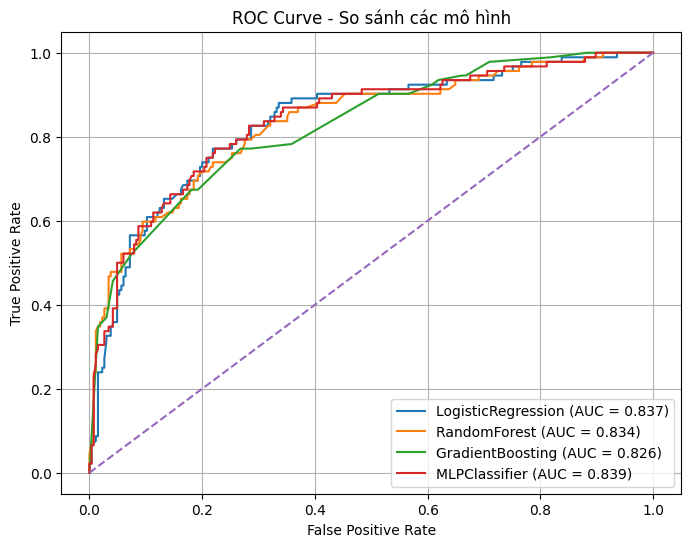

In [32]:
plt.figure(figsize=(8, 6))

for name, fm in fitted_models.items():
    y_proba = fm["y_proba"]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - So sánh các mô hình")
plt.legend()
plt.grid(True)
plt.show()


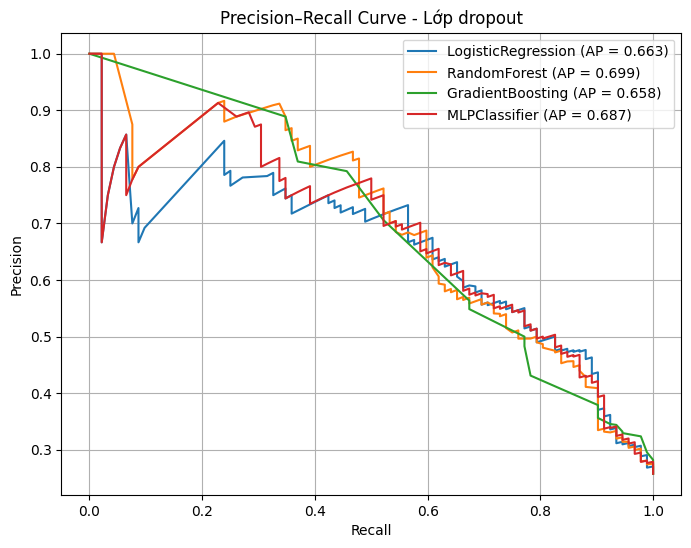

In [33]:
plt.figure(figsize=(8, 6))

for name, fm in fitted_models.items():
    y_proba = fm["y_proba"]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Lớp dropout")
plt.legend()
plt.grid(True)
plt.show()


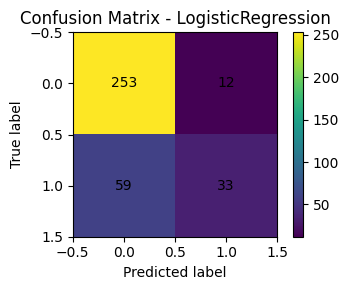

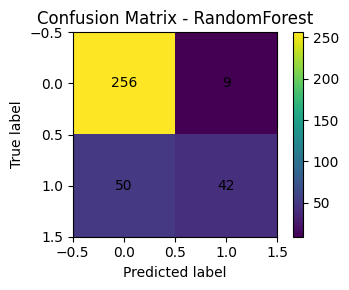

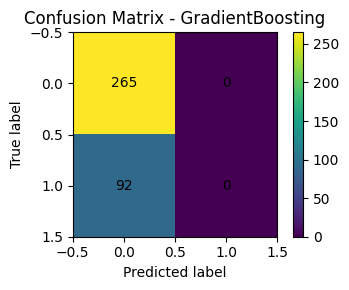

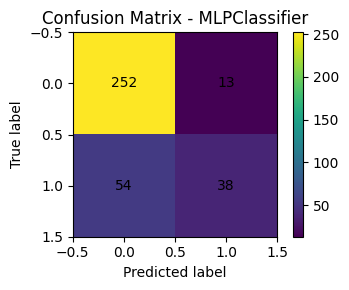

In [34]:
for name, fm in fitted_models.items():
    y_pred = fm["y_pred"]
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # Ghi số lên ô
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
            )

    plt.colorbar()
    plt.tight_layout()
    plt.show()


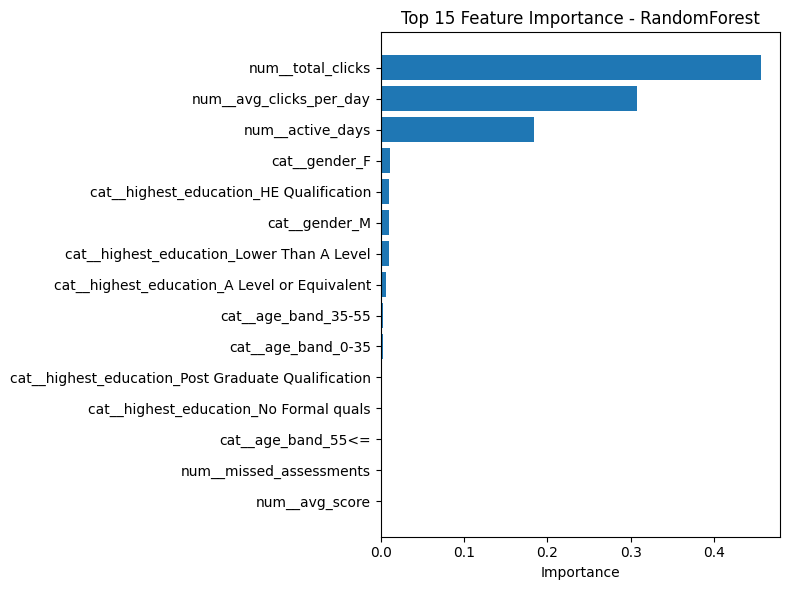

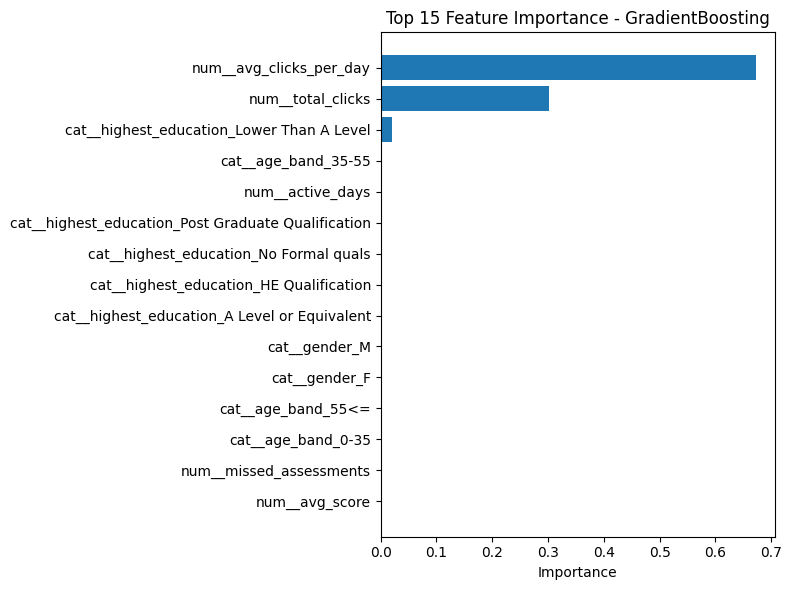

In [35]:
tree_based = ["RandomForest", "GradientBoosting"]

for name in tree_based:
    if name not in fitted_models:
        continue

    pipe = fitted_models[name]["pipeline"]
    classifier = pipe.named_steps["classifier"]

    if not hasattr(classifier, "feature_importances_"):
        continue

    importances = classifier.feature_importances_
    feature_names = pipe.named_steps["preprocess"].get_feature_names_out()

    sorted_idx = np.argsort(importances)[::-1]
    top_n = 15

    plt.figure(figsize=(8, 6))
    plt.barh(
        np.array(feature_names)[sorted_idx][:top_n],
        importances[sorted_idx][:top_n],
    )
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importance - {name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
